In [1037]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import floor

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Define the model class

In [1064]:
class MVEModel(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hidden_dims_mean, 
                 hidden_dims_var,
                 output_dim=14,
                 batch_norm = False,
                 dropout_mean=0.0, 
                 dropout_var=0.0,
                 softmax = True):
        super().__init__()
        self.output_dim = output_dim
        self.softmax = softmax
        # Shared input layer (optional transformation)
        # self.input_layer = nn.Sequential(
        #     nn.Linear(input_dim, input_dim),
        #     nn.ELU()
        # )

        # Mean branch
        mean_layers = []
        prev_dim = input_dim
        for h in hidden_dims_mean:
            mean_layers.append(nn.Linear(prev_dim, h))
            if batch_norm: mean_layers.append(nn.BatchNorm1d(h))
            mean_layers.append(nn.ELU())
            if dropout_mean > 0.0:
                mean_layers.append(nn.Dropout(p=dropout_mean))
            prev_dim = h
        mean_layers.append(nn.Linear(prev_dim, output_dim))
        self.mean_net = nn.Sequential(*mean_layers)

        # Variance branch
        var_layers = []
        prev_dim = input_dim
        for h in hidden_dims_var:
            var_layers.append(nn.Linear(prev_dim, h))
            if batch_norm: var_layers.append(nn.BatchNorm1d(h))
            var_layers.append(nn.ELU())
            if dropout_var > 0.0:
                var_layers.append(nn.Dropout(p=dropout_var))
            prev_dim = h
        var_layers.append(nn.Linear(prev_dim, output_dim))
        self.var_net = nn.Sequential(*var_layers)
        self.var_net[-1].bias.data.fill_(1.0)

    def forward(self, x):
        x = x.to(device)
        # x_base = self.input_layer(x)
        mu = self.mean_net(x)
        if self.softmax: mu = F.softmax(mu, dim=1)      # mean prediction in [0,1]
        var = F.softplus(self.var_net(x)) + 1e-6      # positive variance
        return mu, var

# Loss definitions

## Simple Gaussian NLL loss

In [1068]:
def gaussian_nll(mu, var, target):
    return ((target - mu) ** 2) / var + torch.log(var)

## Batch-appropriate GNLLL

In [11]:
def gaussian_nll_loss(mu, var, targets, eps=1e-6, reduction='mean'):
    var = var + eps
    loss = ((targets - mu) ** 2) / var + torch.log(var)
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    elif reduction == 'none':
        return loss
    else:
        raise ValueError(f"Invalid reduction: {reduction}")

## Masked and weighted

In [14]:
def masked_weighted_gaussian_nll(mu, var, target, eps=1e-6):
    mask = (target != -1)
    mu = mu[mask]
    var = var[mask]
    target = target[mask]

    num_zeros = (target == 0).sum().float()
    num_ones = (target == 1).sum().float()
    total = num_zeros + num_ones

    if total == 0:
        return torch.tensor(0.0, device=mu.device, requires_grad=True)

    weight_0 = 0.5 / (num_zeros + eps)
    weight_1 = 0.5 / (num_ones + eps)
    weights = torch.where(target == 0, weight_0, weight_1)

    nll = ((target - mu) ** 2) / (var + eps) + torch.log(var + eps)
    weighted_nll = weights * nll
    return weighted_nll.sum() / weights.sum()

# Optimizer configuration

In [650]:
def build_optimizer(model, 
                    #lr_mean, 
                    #lr_var, 
                    wd_mean=0.1, 
                    wd_var=0.1, 
                    #lr_shared=None
                   ):
    #if lr_shared is None:
    #    lr_shared = min(lr_mean, lr_var)

    param_groups = [
        {'params': model.mean_net.parameters(), 
         #'lr': lr_mean, 
         'weight_decay': wd_mean
        },
        {'params': model.var_net.parameters(), 
         #'lr': lr_var, 
         'weight_decay': wd_var
        },
        #{'params': model.input_layer.parameters(), 'lr': lr_shared, 'weight_decay': 0.0}
    ]
    return torch.optim.Adam(param_groups)

# Train model

In [20]:
class ToyDataset(Dataset):
    def __init__(self, X, y):
        if not hasattr(X, 'values'):
            self.features = torch.tensor(X, dtype = torch.float)
        else:
            self.features = torch.tensor(X.values, dtype = torch.float)
        if not hasattr(y, 'values'):
            self.labels = torch.tensor(y, dtype = torch.float)
        else:
            self.labels = torch.tensor(y.values, dtype = torch.float)
    def __getitem__(self, index):
        one_x = self.features[index]
        one_y = self.labels[index]
        return one_x, one_y
    def __len__(self):
        return self.labels.shape[0]

## Simple

In [1092]:
import csv
import torch
import torch.nn.functional as F
from torch.nn.utils import clip_grad_value_

def get_per_layer_grad_norms(model):
    grad_norms = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norms[f'grad_{name}'] = param.grad.data.norm(2).item()
        else:
            grad_norms[f'grad_{name}'] = 0.0
    return grad_norms

def train_model_n(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=50,
    warmup_epochs=10, # Only train mean for this many epochs
    freeze_mean = False,
    device='cpu',
    save_path='best_model.pt',
    log_path='training_log.csv',
    clip_value=5.0,                     # NEW: gradient value clipping
    verbose=True
):
    model.to(device)
    log_list = []

    final_train_loss = None
    final_val_loss = None
    final_train_rmse = None
    final_val_rmse = None

    mean_training_on = True

    for epoch in range(num_epochs):
        model.train()

        # 🔄 Freeze or unfreeze variance branch
        var_training_on = epoch >= warmup_epochs
        if freeze_mean: 
            mean_training_on = not var_training_on # If we're freezing the mean, we do so only when training the variance
        for p in model.var_net.parameters():
            p.requires_grad = var_training_on
        for p in model.mean_net.parameters():
            p.requires_grad = mean_training_on

        total_train_loss = 0.0
        total_train_mse = 0.0
        total_samples = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            mu, var = model(x_batch)

            loss = gaussian_nll(mu, var, y_batch).mean()
            loss.backward()

            # 🔒 Clip gradient values instead of norms
            clip_grad_value_(model.parameters(), clip_value)

            optimizer.step()

            total_train_loss += loss.cpu().item() * y_batch.size(0)
            total_train_mse += F.mse_loss(mu, y_batch, reduction='sum').cpu().item()
            total_samples += y_batch.size(0)

        avg_train_loss = total_train_loss / total_samples
        # train_rmse = (total_train_mse / total_samples) ** 0.5
        train_rmse = F.mse_loss(model(train_loader.dataset.features)[0].to(device), 
                                train_loader.dataset.labels.to(device), 
                                reduction = 'mean').item()
        train_rmse = train_rmse ** 0.5

        # param_dict = dict(model.named_parameters())
        # for k,v in param_dict.items():
        #     if 'bias' in k:
        #         print(k,v)

        # --- Validation ---
        model.eval()
        total_val_loss = 0.0
        total_val_mse = 0.0
        total_val_samples = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                mu_val, var_val = model(x_val)
                val_loss = gaussian_nll(mu_val, var_val, y_val).mean()
                total_val_loss += val_loss.item() * y_val.size(0)
                total_val_mse += F.mse_loss(mu_val, y_val, reduction='sum').item()
                total_val_samples += y_val.size(0)

        avg_val_loss = total_val_loss / total_val_samples
        val_rmse = (total_val_mse / total_val_samples) ** 0.5

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} | ",
                  f"Train Loss: {avg_train_loss:.4f} | Train RMSE: {train_rmse:.4f} | ",
                  f"Val Loss: {avg_val_loss:.4f} | Val RMSE: {val_rmse:.4f} | ",
                  f"{'✓' if var_training_on else '⏳'} Var Branch")

        torch.save(model.state_dict(), save_path)

        grads = get_per_layer_grad_norms(model)
        log_entry = {
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'variance_training_on': var_training_on
        }
        log_entry.update(grads)
        log_list.append(log_entry)

        final_train_loss = avg_train_loss
        final_val_loss = avg_val_loss
        final_train_rmse = train_rmse
        final_val_rmse = val_rmse

    # Save logs
    with open(log_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=list(log_list[0].keys()))
        writer.writeheader()
        writer.writerows(log_list)
    if verbose:
        print(f"📊 Training log saved to {log_path}")

    return {
        'train_loss': final_train_loss,
        'val_loss': final_val_loss,
        'train_rmse': final_train_rmse,
        'val_rmse': final_val_rmse
    }


## Old

In [1095]:
# def train_model(
#     model,
#     loss_fcn,
#     train_loader,
#     val_loader,
#     optimizer,
#     num_epochs,
#     delta=0.01,
#     patience=5,
#     device='cpu',
#     save_path=None,
#     verbose = False
# ):
#     metrics = pd.DataFrame(index = range(num_epochs))
#     model.to(device)
#     best_val_loss = float('inf')
#     epochs_without_improvement = 0
#     var_training_started = False
#     variance_train_epoch = None

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0.0
#         total_train_mse = 0.0
#         num_train_batches = 0

#         # Freeze or unfreeze variance branch
#         for p in model.var_net.parameters():
#             p.requires_grad = var_training_started

#         for x_batch, y_batch in train_loader:
#             x_batch = x_batch.to(device)
#             y_batch = y_batch.to(device)

#             optimizer.zero_grad()
#             mu, var = model(x_batch)
#             loss = loss_fcn(mu, var, y_batch)
#             loss.backward()
#             # 🔒 Clip gradients
#             # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=5.0)
#             optimizer.step()

#             total_train_loss += loss.item()
#             num_train_batches += 1

#         avg_train_loss = total_train_loss / num_train_batches

#         # -------------------------
#         # Validation
#         # -------------------------
#         model.eval()
#         total_val_loss = 0.0
#         total_val_mse = 0.0
#         num_val_batches = 0
#         with torch.no_grad():
#             for x_val, y_val in val_loader:
#                 x_val = x_val.to(device)
#                 y_val = y_val.to(device)

#                 mu_val, var_val = model(x_val)
#                 val_loss = loss_fcn(mu_val, var_val, y_val)
#                 val_mse = F.mse_loss(mu_val[y_val != -1], y_val[y_val != -1], reduction='mean')

#                 total_val_loss += val_loss.item()
#                 total_val_mse += val_mse.item()
#                 num_val_batches += 1

#         avg_val_loss = total_val_loss / num_val_batches
#         avg_val_mse = total_val_mse / num_val_batches

#         # Trigger variance training
#         if not var_training_started and avg_val_mse < delta:
#             var_training_started = True
#             variance_train_epoch = epoch + 1
#             print(f"🔓 Variance training activated at epoch {variance_train_epoch} (val MSE={avg_val_mse:.4f})")

#         metrics.loc[epoch, 'train_loss'] = avg_train_loss
#         metrics.loc[epoch, 'val_loss'] = avg_val_loss
#         metrics.loc[epoch, 'val_rmse'] = np.sqrt(avg_val_mse)

#         if verbose: print(f"Epoch {epoch+1}/{num_epochs} | "
#               f"Train Loss: {avg_train_loss:.4f} | "
#               f"Val Loss: {avg_val_loss:.4f} | "
#               f"Val MSE: {np.sqrt(avg_val_mse):.4f}")

#         # Early stopping and saving best model
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             epochs_without_improvement = 0
#             if save_path:
#                 torch.save(model.state_dict(), save_path)
#                 print(f"💾 Saved best model to {save_path}")
#         else:
#             epochs_without_improvement += 1
#             if epochs_without_improvement >= patience:
#                 print(f"🛑 Early stopping at epoch {epoch+1} (no improvement for {patience} epochs).")
#                 break

#     print(f"Epoch {epoch+1}/{num_epochs} | "
#               f"Train Loss: {avg_train_loss:.4f} | "
#               f"Val Loss: {avg_val_loss:.4f} | "
#               f"Val MSE: {np.sqrt(avg_val_mse):.4f}")    

#     if variance_train_epoch:
#         print(f"📌 Variance training started at epoch {variance_train_epoch}.")
#     else:
#         print("⚠️ Variance training was never triggered.")

#     return metrics

# Build models

In [1098]:
def run_experiment(
    device,
    dataset, 
    n_folds,
    hidden_dims_mean, 
    hidden_dims_var, 
    dropout_mean, 
    dropout_var, 
    wd_mean, 
    wd_var, 
    num_epochs, 
    warmup_epochs,
    freeze_mean = False,
    batch_norm = False):
    '''
    dataset: string telling you which of the UCI datasets you want to use for the experiment
    warmup_epochs: tells you 
    freeze_mean: boolean telling us whether to freeze the mean estimation when we start estimating the variance
    batch_norm: boolean telling us whether to insert batch normalization layers into the network
    '''
    with open(f"UCI_Datasets/{dataset}/data/data.txt","r") as f:
        data = pd.read_csv(f, header=None, sep='\s+')
    print(f"{dataset}: Read in {len(data):,} observations of {len(data.columns):,} variables.")
    with open(f"UCI_Datasets/{dataset}/data/index_features.txt","r") as f:
        features = np.ravel(pd.read_csv(f, header=None))
    with open(f"UCI_Datasets/{dataset}/data/index_target.txt","r") as f:
        target = np.ravel(pd.read_csv(f, header=None))
    
    rmse_results = pd.DataFrame(columns = ['train','val','overall'])
    
    kf = KFold(n_folds)
    for i, (train_idx, val_idx) in enumerate(kf.split(data)):
        print(f"===FOLD {i}===")
        
        sc_features = StandardScaler()
        sc_labels = StandardScaler()
    
        X_train = data.loc[train_idx, features]
        y_train = data.loc[train_idx, target]
        X_train = sc_features.fit_transform(X_train)
        y_train = sc_labels.fit_transform(y_train)

        kf_inner = KFold(10)
        l2_constants = [1e-1,1e-2,1e-3,1e-4]
        hypertune = pd.Series(index = pd.MultiIndex.from_product((range(10),l2_constants,l2_constants), 
                                    names = ['fold','mean_decay','var_decay']), 
                                    # columns = ['train_loss','val_loss','train_rmse','val_rmse']
                             )
        for j, (train_idx_i, val_idx_i) in enumerate(kf.split(X_train)):
            print(f"===INNER FOLD {j}===")
            sc_features_i = StandardScaler()
            sc_labels_i = StandardScaler()

            X_train_i = X_train[train_idx_i,:]
            y_train_i = y_train[train_idx_i]
            X_train_i = sc_features_i.fit_transform(X_train_i)
            y_train_i = sc_labels_i.fit_transform(y_train_i)
            
            X_val_i = sc_features_i.transform(X_train[val_idx_i,:])
            y_val_i = sc_labels_i.transform(y_train[val_idx_i])
            for l2_mean in l2_constants:
                for l2_var in l2_constants:
                    current_best_trial = hypertune.loc[j].idxmin()
                    
                    train_loader_i = DataLoader(
                    dataset=ToyDataset(X_train_i, y_train_i),
                    batch_size=32,
                    shuffle=True,
                    num_workers=0)
    
                    val_loader_i = DataLoader(
                    dataset=ToyDataset(X_val_i, y_val_i),
                    batch_size=32,
                    shuffle=False,
                    num_workers=0)
    
                    model_params = {
                                'input_dim': len(features),
                                'hidden_dims_mean': hidden_dims_mean,
                                'hidden_dims_var': hidden_dims_var,
                                'output_dim': 1,
                                'batch_norm': False,
                                'softmax': False, 
                                'dropout_mean': dropout_mean, 
                                'dropout_var': dropout_var}
    
                    model = MVEModel(**model_params).to(device)
    
                    model_optim = build_optimizer(model, wd_mean = l2_mean, wd_var = l2_var)
    
                    train_model_n(model, 
                            train_loader=train_loader_i,
                            val_loader=val_loader_i,
                            optimizer=model_optim,
                            num_epochs=num_epochs,
                            warmup_epochs=warmup_epochs,
                            verbose = False,
                            device = 'mps',
                            freeze_mean = freeze_mean
                               )
                    with torch.no_grad():
                        val_mu = torch.tensor(sc_labels_i.inverse_transform(model(val_loader_i.dataset.features)[0].detach()), dtype = torch.float)
                        val_var = model(val_loader_i.dataset.features)[1].detach()
                    val_labels = torch.tensor(sc_labels_i.inverse_transform(val_loader_i.dataset.labels), dtype = torch.float)
                    val_loss = gaussian_nll(val_mu, val_var, val_labels).mean().item()
                    #print(f"val loss for {j}, {l2_mean}, {l2_var} is {val_loss}.")
                    hypertune.loc[j, l2_mean, l2_var] = val_loss

                    best_performance_loc = hypertune.loc[j].idxmin()
                    if best_performance_loc != current_best_trial:
                        #print(f"Current minimum loglikelihood: {hypertune.idxmin()}.")
                        #print(f"Current best trial: {current_best_trial}.")
                        print(f"Current new best performance of {hypertune.loc[j].loc[best_performance_loc]} at {best_performance_loc}.")

        final_l2_mean, final_l2_var = hypertune.groupby(['mean_decay','var_decay']).mean().idxmin()
        
        X_val = sc_features.transform(data.loc[val_idx, features])
        y_val = sc_labels.transform(data.loc[val_idx, target])
    
        train_loader = DataLoader(
        dataset=ToyDataset(X_train, y_train),
        batch_size=32,
        shuffle=True,
        num_workers=0)
    
        val_loader = DataLoader(
        dataset=ToyDataset(X_val, y_val),
        batch_size=32,
        shuffle=False,
        num_workers=0)
    
        model_params = {
                    'input_dim': len(features),
                    'hidden_dims_mean': hidden_dims_mean,
                    'hidden_dims_var': hidden_dims_var,
                    'output_dim': 1,
                    'batch_norm': False,
                    'softmax': False, 
                    'dropout_mean': dropout_mean, 
                    'dropout_var': dropout_var}
    
        model = MVEModel(**model_params)
        if i == 0:
            param_dict = dict(model.named_parameters())
            num_params = 0
            for k,v in param_dict.items():
                num_params += reduce(lambda x,y: x*y, v.shape)
            print(f"MVEModel has {num_params:,} trainable parameters.")
            
        print(f"Building optimizer with regularization constants {final_l2_mean} (mu) and {final_l2_var} (sigma**2).")
        model_optim = build_optimizer(model, wd_mean = final_l2_mean, wd_var = final_l2_var)
    
        train_model_n(model, 
                train_loader=train_loader,
                val_loader=val_loader,
                optimizer=model_optim,
                num_epochs=num_epochs,
                warmup_epochs=warmup_epochs,
                verbose = False,
                freeze_mean = freeze_mean
                   )
    
        train_pred = torch.tensor(sc_labels.inverse_transform(model(train_loader.dataset.features)[0].detach()), 
                                  dtype = torch.float).to(device)
        train_labels = torch.tensor(sc_labels.inverse_transform(train_loader.dataset.labels), 
                                    dtype = torch.float).to(device)
        
        val_pred = torch.tensor(sc_labels.inverse_transform(model(val_loader.dataset.features)[0].detach()), 
                                dtype = torch.float).to(device)
        val_labels = torch.tensor(sc_labels.inverse_transform(val_loader.dataset.labels), 
                                  dtype = torch.float).to(device)
        
        all_pred = torch.vstack((train_pred, val_pred))
        all_labels = torch.vstack((train_labels, val_labels))
        
        pred_label_pairs = [(train_pred, train_labels), (val_pred, val_labels), (all_pred, all_labels)]
        train_rmse, val_rmse, overall_rmse = [F.mse_loss(x,y).item() ** 0.5 for x,y in pred_label_pairs]
        #print(f"Train RMSE: {train_rmse:.3f} | "
        #      f"Val RMSE: {val_rmse:.3f} | "
        #      f"Overall RMSE: {overall_rmse:.3f}")
        rmse_results.loc[i,:] = train_rmse, val_rmse, overall_rmse
    return rmse_results

In [1100]:
experiment_args = {
    'device':device,
    'dataset':'bostonHousing',
    'n_folds':10,
    'hidden_dims_mean':[40,20],
    'hidden_dims_var':[40,20],
    'dropout_mean':0, 'dropout_var':0, # We don't use dropout
    'wd_mean':.1, 'wd_var':.1,
    'num_epochs':1000,
    'freeze_mean':False,
    'warmup_epochs':0,
}

In [1033]:
results

,train,val,overall
0,3.244257,3.466682,3.267362
1,3.540886,2.267828,3.434027
2,3.472924,2.799229,3.411057
3,3.329491,5.117614,3.55076
4,3.419387,2.962926,3.376178
5,3.409656,2.672878,3.342763
6,3.473175,2.679181,3.402975
7,2.286416,10.231314,3.880075
8,2.995707,4.373176,3.158681
9,3.364845,3.207492,3.349625


In [1102]:
for dataset in ['bostonHousing',
                # 'energy',
                # 'yacht',
                # 'concrete',
                # 'wine-quality-red'
               ]:
    print(f"==={dataset}===")
    experiment_args['dataset'] = dataset
    for warmup in [0]:
        experiment_args['warmup_epochs'] = warmup
        results = run_experiment(**experiment_args)
        print(f"We have an overall RMSE of {results['overall'].mean():.3f} +/- {results['overall'].std():.3f}")

===bostonHousing===
bostonHousing: Read in 506 observations of 14 variables.
===FOLD 0===
===INNER FOLD 0===


/var/folders/fc/3j61cxq953388m2stsv1h12c0000gn/T/ipykernel_21086/4007394324.py:63: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  current_best_trial = hypertune.loc[j].idxmin()


KeyboardInterrupt: 

In [1019]:
results

,train,val,overall
0,3.244257,3.466682,3.267362
1,3.540886,2.267828,3.434027
2,3.472924,2.799229,3.411057
3,3.329491,5.117614,3.55076
4,3.419387,2.962926,3.376178
5,3.409656,2.672878,3.342763
6,3.473175,2.679181,3.402975
7,2.286416,10.231314,3.880075
8,2.995707,4.373176,3.158681
9,3.364845,3.207492,3.349625


In [699]:
for dataset in ['bostonHousing','energy','yacht','concrete','wine-quality-red']:
    print(f"==={dataset}===")
    experiment_args['dataset'] = dataset
    for warmup in [0,100]:
        experiment_args['warmup_epochs'] = warmup
        results = run_experiment(**experiment_args)
        print(f"We have an overall RMSE of {results['overall'].mean():.3f} +/- {results['overall'].std():.3f}")

===bostonHousing===
bostonHousing: Read in 506 observations of 14 variables.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
We have an overall RMSE of 3.432 +/- 0.189
bostonHousing: Read in 506 observations of 14 variables.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
MVEModel has 2,802 trainable parameters.
We 

In [620]:
from functools import reduce

In [642]:
test_model = MVEModel(input_dim = 4, hidden_dims_mean=[3,2], hidden_dims_var=[3,2], output_dim = 1)

param_dict = dict(test_model.named_parameters())
num_params = 0
for k,v in param_dict.items():
    num_params += reduce(lambda x,y: x*y, v.shape)

In [646]:
num_params = 0
for k,v in param_dict.items():
    num_params += reduce(lambda x,y: x*y, v.shape)

mean_net.0.weight torch.Size([3, 4])
mean_net.0.bias torch.Size([3])
mean_net.2.weight torch.Size([2, 3])
mean_net.2.bias torch.Size([2])
mean_net.4.weight torch.Size([1, 2])
mean_net.4.bias torch.Size([1])
var_net.0.weight torch.Size([3, 4])
var_net.0.bias torch.Size([3])
var_net.2.weight torch.Size([2, 3])
var_net.2.bias torch.Size([2])
var_net.4.weight torch.Size([1, 2])
var_net.4.bias torch.Size([1])


In [542]:
dataset = experiment_args['dataset']

with open(f"UCI_Datasets/{dataset}/data/data.txt","r") as f:
    data = pd.read_csv(f, header=None, sep='\s+')
print(f"{dataset}: Read in {len(data):,} observations of {len(data.columns):,} variables.")
with open(f"UCI_Datasets/{dataset}/data/index_features.txt","r") as f:
    features = np.ravel(pd.read_csv(f, header=None))
with open(f"UCI_Datasets/{dataset}/data/index_target.txt","r") as f:
    target = np.ravel(pd.read_csv(f, header=None))

n_folds = 10

kf = KFold(n_folds)
rmse_results = pd.DataFrame(columns = ['train','val','overall'])

for i, (train_idx, val_idx) in enumerate(kf.split(data)):
    print(f"Working on Fold {i}...")
    
    sc_features = StandardScaler()
    sc_labels = StandardScaler()

    X_train = data.loc[train_idx, features]
    y_train = data.loc[train_idx, target]
    X_train = sc_features.fit_transform(X_train)
    y_train = sc_labels.fit_transform(y_train)
    
    X_val = sc_features.transform(data.loc[val_idx, features])
    y_val = sc_labels.transform(data.loc[val_idx, target])

    train_loader = DataLoader(
    dataset=ToyDataset(X_train, y_train),
    batch_size=32,
    shuffle=True,
    num_workers=0)

    val_loader = DataLoader(
    dataset=ToyDataset(X_val, y_val),
    batch_size=32,
    shuffle=False,
    num_workers=0)

    model_params = {
                'input_dim': len(features),
                'hidden_dims_mean': experiment_args['hidden_dims_mean'],
                'hidden_dims_var': experiment_args['hidden_dims_var'],
                'output_dim': 1,
                'softmax': False, 
                'dropout_mean': experiment_args['dropout_mean'], 
                'dropout_var': experiment_args['dropout_var']}

    model = MVEModel(**model_params)

    model_optim = build_optimizer(model, lr_mean = .1, lr_var = .1)

    train_model_n(model, 
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=model_optim,
            num_epochs=experiment_args['num_epochs'],
            warmup_epochs=experiment_args['warmup_epochs'],
            verbose = False,
               )

    # metrics = train_model(model, 
    #         loss_fcn = gaussian_nll_loss,
    #         train_loader=train_loader,
    #         val_loader=val_loader,
    #         optimizer=model_optim,
    #         num_epochs=1000,
    #         patience = 1000,
    #         delta = np.inf, 
    #         verbose = True,
    #            )
    # print(metrics)
    train_pred = torch.tensor(sc_labels.inverse_transform(model(train_loader.dataset.features)[0].detach()), dtype = torch.float)
    train_labels = torch.tensor(sc_labels.inverse_transform(train_loader.dataset.labels), dtype = torch.float)
    
    val_pred = torch.tensor(sc_labels.inverse_transform(model(val_loader.dataset.features)[0].detach()), dtype = torch.float)
    val_labels = torch.tensor(sc_labels.inverse_transform(val_loader.dataset.labels), dtype = torch.float)
    
    all_pred = torch.vstack((train_pred, val_pred))
    all_labels = torch.vstack((train_labels, val_labels))
    
    pred_label_pairs = [(train_pred, train_labels), (val_pred, val_labels), (all_pred, all_labels)]
    train_rmse, val_rmse, overall_rmse = [F.mse_loss(x,y).item() ** 0.5 for x,y in pred_label_pairs]
    #print(f"Train RMSE: {train_rmse:.3f} | "
    #      f"Val RMSE: {val_rmse:.3f} | "
    #      f"Overall RMSE: {overall_rmse:.3f}")
    rmse_results.loc[i,:] = train_rmse, val_rmse, overall_rmse

print(f"We have an overall RMSE of {rmse_results['overall'].mean():.3f} +/- {rmse_results['overall'].std():.3f}")

bostonHousing: Read in 506 observations of 14 variables.
Working on Fold 0...
Working on Fold 1...
Working on Fold 2...
Working on Fold 3...
Working on Fold 4...
Working on Fold 5...
Working on Fold 6...
Working on Fold 7...
Working on Fold 8...
Working on Fold 9...
We have an overall RMSE of 5.243 +/- 3.508


In [538]:
rmse_results

,train,val,overall
0,1.930039,4.289692,2.937151
1,3.674543,4.799611,4.084917
2,2.754705,39.499169,22.870827


In [ ]:
We have an overall RMSE of 3.011 +/- 0.532

In [489]:
We have an overall RMSE of 3.456 +/- 0.350

3.4669265511192933

In [1198]:
results1 = model(torch.tensor(sc.transform(data.loc[:,features]), dtype = torch.float))

In [1180]:
n_folds = 10

kf = KFold(n_folds)
rmse_results = pd.Series()

for i, (train_idx, test_idx) in enumerate(kf.split(data)):
    print(f"FOLD: ==={i}===")
    X_train = data.loc[train_idx, features]
    y_train = data.loc[train_idx, target]
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(data.loc[test_idx, features])
    y_test = data.loc[test_idx, target]

    train_loader = DataLoader(
    dataset=ToyDataset(X_train, y_train),
    batch_size=32,
    shuffle=True,
    num_workers=0)

    val_loader = DataLoader(
    dataset=ToyDataset(X_test, y_test),
    batch_size=32,
    shuffle=False,
    num_workers=0)

    model_params = {'input_dim': len(features),
                'hidden_dims_mean': [40,20],
                'hidden_dims_var': [40,20],
                'output_dim': 1,
                'softmax': False, 
                'dropout_mean': 0.2, 
                'dropout_var': 0.3}

    model = MVEModel(**model_params)

    model_optim = build_optimizer(model, lr_mean = .01, lr_var = .01)

    # metrics = train_model_n(model, 
    #         # loss_fcn = gaussian_nll_loss,
    #         train_loader=train_loader,
    #         val_loader=val_loader,
    #         optimizer=model_optim,
    #         num_epochs=1000,
    #         warmup_epochs=0,
    #         verbose = False,
    #            )
    
    metrics = train_model(model, 
            loss_fcn = gaussian_nll_loss,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=model_optim,
            num_epochs=1000,
            patience = 1000,
            delta = np.inf, 
            verbose = False,
               )
    print(metrics)
    rmse_results.loc[i] = metrics['val_rmse']

FOLD: ===0===
🔓 Variance training activated at epoch 1 (val MSE=454.6456)
Epoch 1000/1000 | Train Loss: 2.8651 | Val Loss: 4.5506 | Val MSE: 3.2904
📌 Variance training started at epoch 1.
     train_loss    val_loss   val_rmse
0    794.806925  589.281342  21.322420
1    541.970522  410.050644  21.898502
2    280.037950  147.097122  20.896752
3    142.846119   82.059425  18.086559
4     74.268249   32.565070  14.256516
..          ...         ...        ...
995    3.109714    4.959830   3.563020
996    2.978646    4.848024   3.568775
997    3.087535    4.734168   3.449528
998    2.901279    4.506299   3.334761
999    2.865097    4.550638   3.290374

[1000 rows x 3 columns]
FOLD: ===1===
🔓 Variance training activated at epoch 1 (val MSE=588.2813)
Epoch 1000/1000 | Train Loss: 2.7608 | Val Loss: 2.5427 | Val MSE: 2.4130
📌 Variance training started at epoch 1.
     train_loss    val_loss   val_rmse
0    882.689779  770.735840  24.254511
1    596.485327  473.358566  26.745845
2    342.13321

In [1176]:
print(f"10-fold cross-validation results are {rmse_results.iloc[-1,:].mean():.3f} +/- {rmse_results.iloc[-1,:].std():.3f}")

IndexingError: Too many indexers

<Axes: >

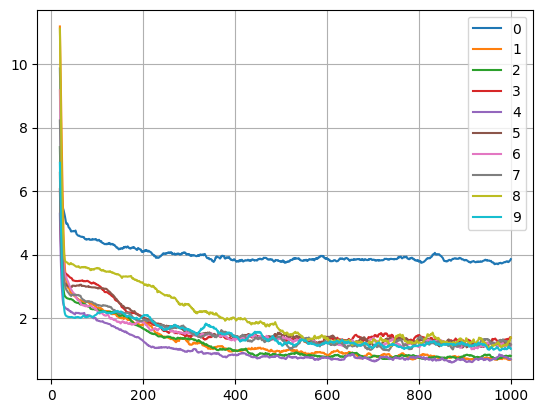

In [1044]:
rmse_results.rolling(20).mean().plot(grid = True)

In [1026]:
rmse_results.std()

0.831450754295852

<Axes: >

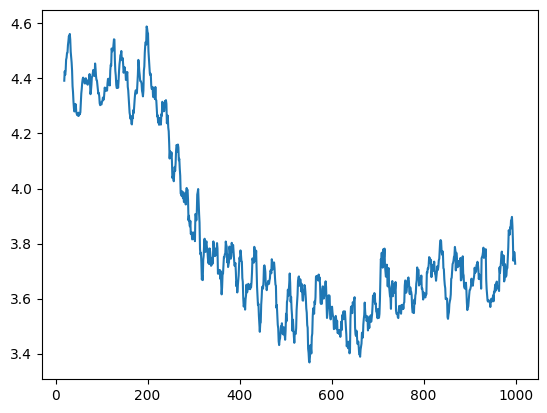

In [1010]:
# metrics['train_loss'].loc[10:].plot()
metrics['val_rmse'].loc[10:].rolling(10).mean().plot()